In [1]:
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, cdist, squareform, cosine
from pymutspec.annotation import calculate_mutspec, CodonAnnotation, mutations_summary, rev_comp, lbl_id2lbl, lbl2lbl_id
from pymutspec.constants import possible_sbs192, possible_codons 
from pymutspec.draw import plot_mutspec192, sbs_orders
from pymutspec.annotation.spectra import complete_sbs192_columns
from pymutspec.io import read_genbank_ref
from sklearn.preprocessing import StandardScaler
import umap

sns.set_style()

In [2]:
coda = CodonAnnotation(2)

## Prepapre data

In [3]:
# Calculate site-specific annotation for reference mtDNA
path_to_gb = "data/NC_012920.1.gb"
Ref = read_genbank_ref(path_to_gb).rename(columns={'gene':"GeneName"})

# Assign time being single-stranded (TBSS) feature for each site
Ref["TBSS"] = np.nan
Ref["TBSS"].loc[(Ref.Pos > 576) & (Ref.Pos < 5721)] = 16569 - (5721 - Ref.Pos) * 2  # minor arc; L-strand replication origin (locus MT-OLR, 5721 - 5798)
Ref["TBSS"].loc[(Ref.Pos > 5798) & (Ref.Pos < 16024)] = (Ref.Pos - 5798) * 2        # major arc

Ref.to_csv("./data/ref_annot.csv", index=None)
Ref

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16564,16565,C,ACG,-1,D-loop,NaN,-1,-1,NaN,NaN
16565,16566,G,CGA,-1,D-loop,NaN,-1,-1,NaN,NaN
16566,16567,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
16567,16568,T,ATG,-1,D-loop,NaN,-1,-1,NaN,NaN


In [5]:
# Read somatic cancer mutations
path_to_obs = "./data/mtDNA_snv_Oct2016.txt"
_cols = "position,ref,var,sample,tissue,Tier2,Annot,tumor_var_freq,is_nonsense,Unnamed: 36".split(",")
ObsAll = pd.read_csv(path_to_obs, sep="\t", usecols=_cols)

ObsAll.rename(columns={"Unnamed: 36": "sbs_raw"}, inplace=True)
ObsAll.rename(columns={"tissue": "cancer_type", "Tier2": "tissue"}, inplace=True)

def replace_sbs(sbs: str):
    new_sbs = sbs[1] + "[" + sbs[2:5] + "]" + sbs[-1]
    if sbs.startswith("p"):
        pass
    elif sbs.startswith("n"):
        new_sbs = rev_comp(new_sbs)
    return new_sbs

ObsAll["sbs"] = ObsAll["sbs_raw"].apply(replace_sbs)
ObsAll["tumor_var_freq"] = ObsAll["tumor_var_freq"].str.rstrip("%").astype(float)
ObsAll

,sample,cancer_type,tissue,position,ref,var,tumor_var_freq,Annot,sbs_raw,is_nonsense,sbs
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,2680,T,C,38.7900,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",pTT>CG,0,T[T>C]G
1,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,6011,T,C,10.1400,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",pTT>CA,0,T[T>C]A
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,7706,G,A,37.3900,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",nGC>TA,0,T[G>A]C
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,9078,T,C,86.5500,"synSNP,MT-ATP6,MT-ATP6,exon1,I184I,5,1;",pTT>CA,0,T[T>C]A
4,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,9686,T,C,1.8500,"synSNP,MT-CO3,MT-CO3,exon1,I160I,5,5;",pTT>CC,0,T[T>C]C
...,...,...,...,...,...,...,...,...,...,...,...
7606,PCSI_0357,PACA,Pancreas,3973,T,C,0.9940,"nsSNP,MT-ND1,MT-ND1,exon1,F223L,0,5;",pAT>CT,0,A[T>C]T
7607,PCSI_0357,PACA,Pancreas,5227,G,A,0.0269,"nsSNP,MT-ND2,MT-ND2,exon1,G253D,-2,5;",nGC>TC,0,G[G>A]C
7608,PCSI_0357,PACA,Pancreas,11711,G,A,0.0132,"nsSNP,MT-ND4,MT-ND4,exon1,A318T,0,5;",nGC>TG,0,C[G>A]C
7609,PCSI_0357,PACA,Pancreas,13352,T,C,0.2710,"nsSNP,MT-ND5,MT-ND5,exon1,L339P,-4,1;",pCT>CA,0,C[T>C]A


In [6]:
# function used to annotate mutations and extract codon after the mutation 
def get_alt(ser: pd.Series):
    if not isinstance(ser["Codon"], str):
        return None
    codon = list(ser["Codon"])
    ref_nuc, alt_nuc = ser["ref"], ser["var"]
    pic = ser["PosInCodon"] - 1
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon

In [7]:
# merge mutations with the reference annotation
mutations = pd.merge(
    ObsAll[["sample", "tissue", "cancer_type", "position", "ref", 
            "var", 'sbs', 'tumor_var_freq']], 
    Ref, left_on=["position", "ref"], right_on=["Pos", "Nuc"],
)
mutations["AltCodon"] = mutations.apply(get_alt, axis=1)

# annotate mutations (Label 0 for non-syn mutations, 1 - for syn, 2 - for syn at 4fold sites)
mutations["Label"] = mutations.apply(
    lambda s: 0 if s.PosInCodon <= 0 else coda.get_mut_type(
        s.Codon, s.AltCodon, s.PosInCodon - 1)[0], axis=1)
mutations["Mut"] = mutations.Context.str.get(0) + "[" + mutations["ref"] + ">" + mutations["var"] + "]" + mutations.Context.str.get(-1)

assert len(mutations[mutations.sbs != mutations.Mut]) == 0, "contexts are not equal"

# save mutations
mutations.drop(["position", "ref", "var", "sbs"], axis=1, inplace=True)
mutations.to_csv('./data/mutations.csv', index=False)
mutations

,sample,tissue,cancer_type,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,None,0,T[T>C]G
1,ICGC_0437,Pancreas,PAEN,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,None,0,T[T>C]G
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,RK135,Liver,LIRI,4.8500,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,CPCG0046,Prostate,PRAD,0.0110,10833,T,ATC,1,CDS,ND4,74,2,ATC,10070.0,ACC,0,A[T>C]C
7607,CPCG0046,Prostate,PRAD,0.0108,12015,T,CTC,1,CDS,ND4,1256,2,CTC,12434.0,CAC,0,C[T>A]C
7608,CPCG0046,Prostate,PRAD,0.0104,15084,G,TGA,1,CDS,CYTB,338,2,TGA,18572.0,TAA,-1,T[G>A]A
7609,PCSI_0357,Pancreas,PACA,0.1804,2908,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10943.0,None,0,T[T>C]G


## EDA of the cancer mutation dataset

### Describe patients
(cancer samples == patients)

There are 835 synonymous mutations in 682 patients of human cancers


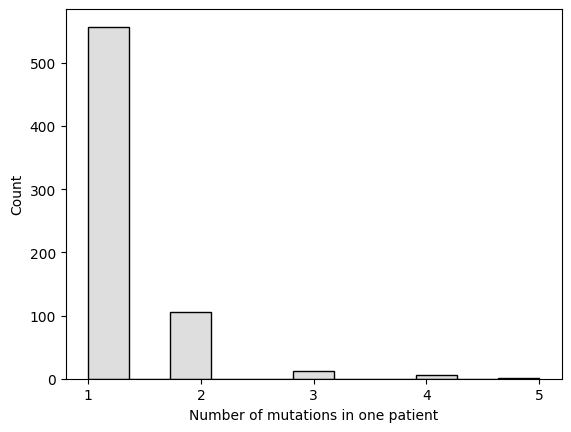

In [8]:
print(f'There are {len(mutations[mutations.Label > 0])} synonymous mutations '
      f'in {mutations[mutations.Label > 0]["sample"].nunique()} patients of human cancers')
ax = sns.histplot(mutations[mutations.Label > 0]['sample'].value_counts(), color='lightgray')
ax.set_xlabel('Number of mutations in one patient')
ax.set_xticks(range(1, 6))
plt.savefig('./figures/patients_mut_num.pdf')
plt.show()

### Describe observed mutations

In [9]:
# number of different mutations in tissues
mutations[mutations.Label == 0].tissue.value_counts().rename('#non-syn').to_frame()\
    .join(mutations[mutations.Label > 0].tissue.value_counts().rename('#syn'))\
        .sort_values('#syn', ascending=False)

,#non-syn,#syn
Liver,1090,136
Kidney,708,91
Pancreas,736,88
Breast,586,77
Prostate,639,66
Esophagus,348,51
Lymphoid,266,44
Ovary,342,42
Skin,176,35
CNS,224,32


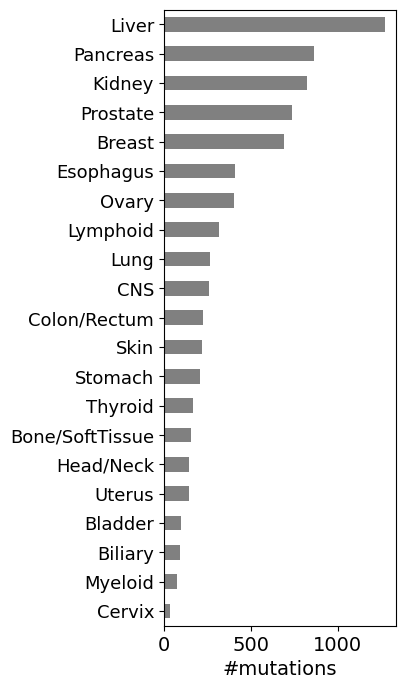

In [10]:
# total number of mutations in tissues
plt.figure(figsize=(3, 8))
mutations.tissue.value_counts(ascending=True).plot.barh(color="gray")
plt.xlabel("#mutations", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.show()

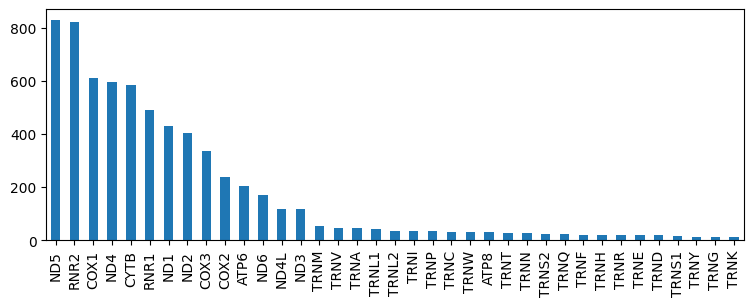

In [11]:
# total number of mutations in genes
plt.figure(figsize=(9, 3))
mutations.GeneName.value_counts().plot.bar();

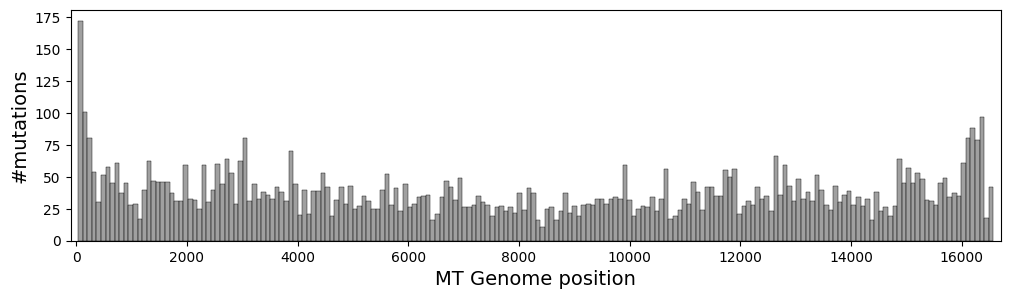

In [12]:
# Distribution of mutaions on the genome
plt.figure(figsize=(12, 3))
plt.xlabel("MT Genome position", fontsize=14)
plt.ylabel("#mutations", fontsize=14)
sns.histplot(mutations.Pos, bins=200, color="gray")
plt.xlim(-100, 16700)
plt.show()

In [13]:
# classification of mutations
mutations_summary(mutations)

,non-syn,syn,syn4f,Stop gain,Stop to stop
_ProbaFull,6488,835,462,278,10


In [14]:
# classification of mutations (gene-specific)
mutations_summary(mutations, gene_col="GeneName")

,non-syn,syn,syn4f,Stop gain,Stop to stop
GeneName,,,,,
ATP6,150,51,31,5,0
ATP8,11,13,2,5,0
COX1,428,124,72,59,0
COX2,184,45,28,9,1
COX3,261,47,22,30,0
CYTB,450,83,49,50,3
ND1,337,74,44,17,3
ND2,285,90,56,27,3
ND3,83,29,7,4,0


## Calculate 192-component spectra

In [15]:
# Frequencies counting
ProtRef = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]

exp_muts192 = dict()
for gene, gtable in ProtRef[ProtRef.Codon.str.len() == 3].groupby("GeneName"):
    assert np.all(gtable.PosInGene == np.arange(1, gtable.shape[0] + 1))
    seq = gtable.Nuc.values
    gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq)
    for lbl in gene_exp_muts12:
        if lbl not in exp_muts192:
            exp_muts192[lbl] = defaultdict(int)

        for sbs, _cnt in gene_exp_muts192[lbl].items():
            exp_muts192[lbl][sbs] += _cnt

lbl = "D-loop"
_, f2 = coda.collect_exp_mut_freqs(Ref[Ref.Type == lbl]["Nuc"].values, labels=["all"])
exp_muts192[lbl] = f2["all"]

lbl = "ExDloop"
_, f2 = coda.collect_exp_mut_freqs(Ref[(~Ref.Type.isin(["D-loop", "misc_feature"]))]["Nuc"].values, labels=["all"])
exp_muts192[lbl] = f2["all"]

In [16]:
# Calculate spectra
MutCDS = mutations[(mutations.Type == "CDS") & (mutations.Strand == 1)]
mutspec192 = pd.DataFrame({"Mut": possible_sbs192})

for lbl in exp_muts192:
    if lbl in {"all", "syn", "ff"}:
        ms192 = calculate_mutspec(MutCDS[MutCDS.Label >= lbl2lbl_id(lbl)], exp_muts192[lbl], use_context=True, use_proba=False)

    elif lbl == "ExDloop":
        _MutExDloop = mutations[(mutations.Type != "D-loop")]  # & (mutations.Label >= 0) & (mutations.Strand == 1)
        ms192 = calculate_mutspec(_MutExDloop, exp_muts192[lbl], use_context=True, use_proba=False)

    else:
        MutCustom = mutations[(mutations.Type == lbl)]
        ms192 = calculate_mutspec(MutCustom, exp_muts192[lbl], use_context=True, use_proba=False)

    ms192.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    mutspec192 = pd.merge(mutspec192, ms192[["Mut", f"MutSpec_{lbl}"]], 'outer', on="Mut")

# Reverse complement of Mut (to Heavy strand)
mutspec192["Mut"] = mutspec192.Mut.apply(rev_comp)
mutspec192["Mut"] = mutspec192["Mut"].astype('category')
mutspec192["Mut"] = mutspec192["Mut"].cat.set_categories(sbs_orders.ordered_sbs192_kp)
mutspec192 = mutspec192.sort_values(by=['Mut']).reset_index(drop=True)

mutspec192.to_csv("./data/cancer_mutspec.csv", index=False, sep=';')
mutspec192

,Mut,MutSpec_syn,MutSpec_all,MutSpec_ff,MutSpec_D-loop,MutSpec_ExDloop
0,A[C>A]A,0.000000,0.000000,0.00000,0.003207,0.000000
1,A[C>A]C,0.000000,0.000000,0.00000,0.000000,0.000699
2,A[C>A]G,0.000000,0.000000,0.00000,0.000000,0.000000
3,A[C>A]T,0.000000,0.000000,0.00000,0.000000,0.000000
4,C[C>A]A,0.000000,0.000955,0.00000,0.014432,0.000550
...,...,...,...,...,...,...
187,A[A>C]C,0.000000,0.001163,0.00000,0.000000,0.000741
188,T[A>C]A,0.000000,0.000000,0.00000,0.000000,0.000000
189,G[A>C]A,0.000000,0.000000,0.00000,0.000000,0.000000
190,C[A>C]A,0.007213,0.001235,0.00878,0.000000,0.000706


In [19]:
### CONTROL CHECK 
### Check that cancer mutspec df is on heavy chain
### Most common MutBases are C>T and A>G, so it's heavy chain
mutspec192['MutBase'] = mutspec192.Mut.str.slice(2, 5)
mutspec192.groupby(['MutBase']).MutSpec_syn.mean().reset_index().sort_values(by='MutSpec_syn', ascending=False)

,MutBase,MutSpec_syn
5,C>T,0.042370
1,A>G,0.012054
6,G>A,0.003124
10,T>C,0.002098
4,C>G,0.000887
8,G>T,0.000635
0,A>C,0.000451
9,T>A,0.000434
11,T>G,0.000318
7,G>C,0.000105


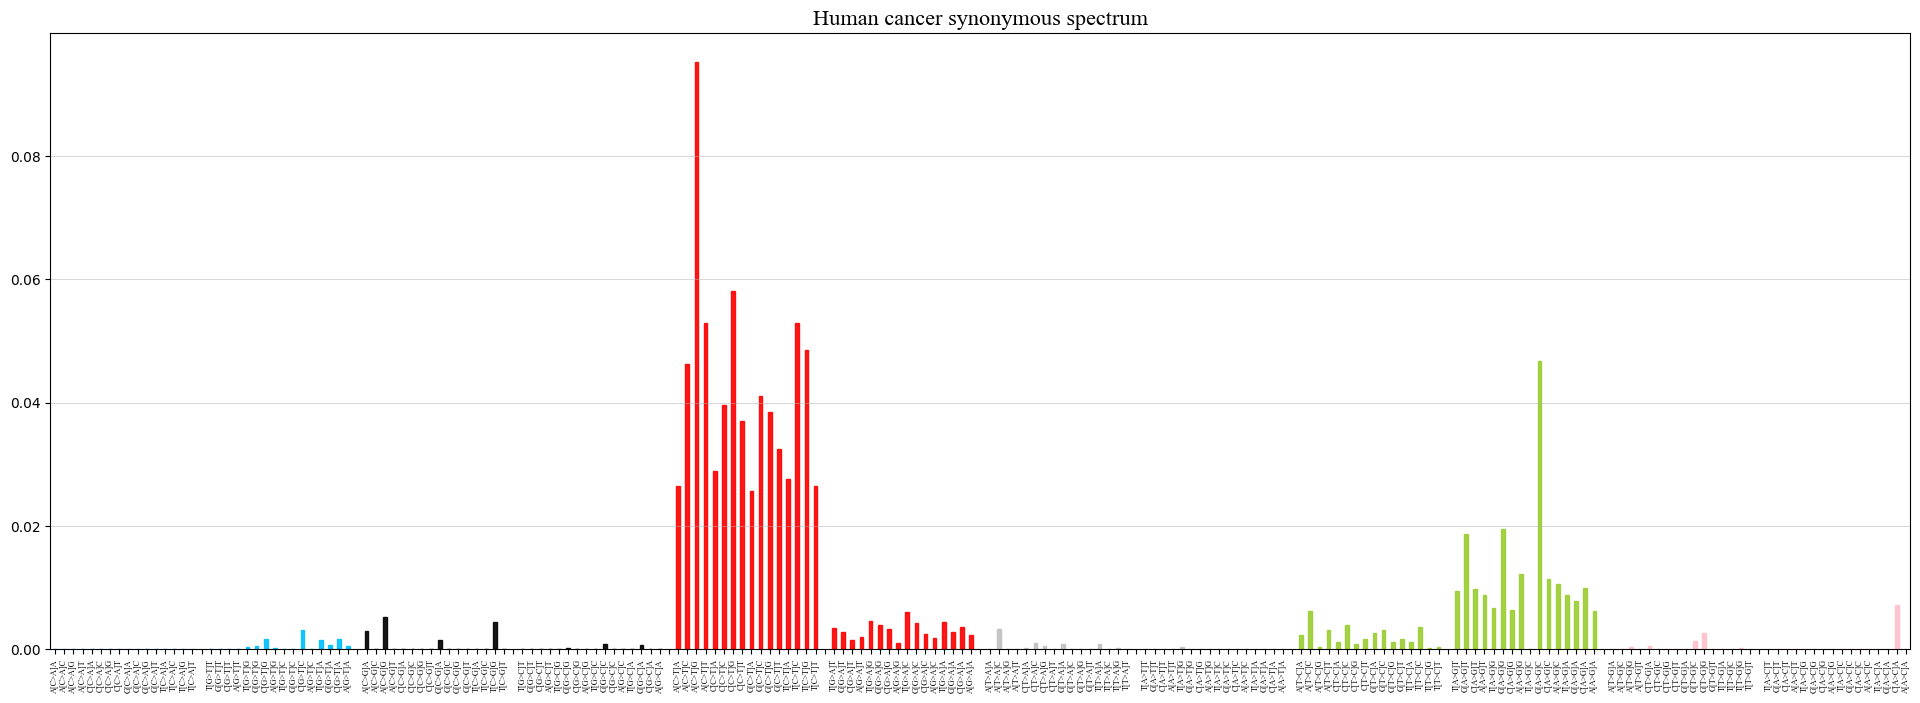

In [47]:
plot_mutspec192(mutspec192, 'MutSpec_syn', 'Human cancer synonymous spectrum', savepath='./figures/syn_spectrum.pdf');

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


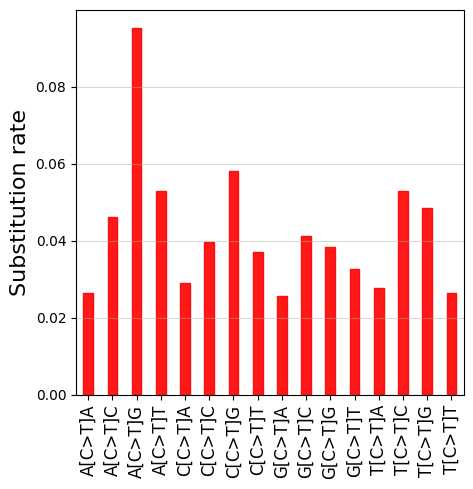

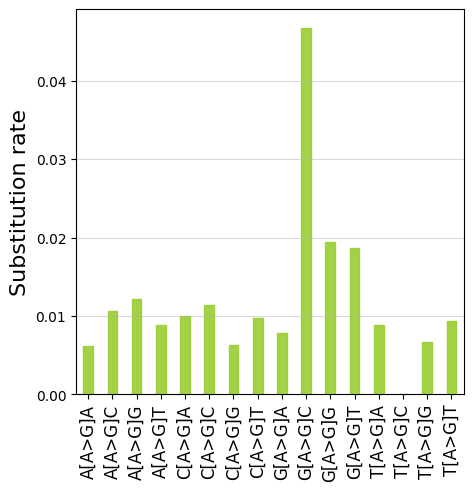

<AxesSubplot:ylabel='Substitution rate'>

In [49]:
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

plot_mutspec192(mutspec192, 'MutSpec_syn', title="", ylabel="Substitution rate",  fontname="Courier", 
                ticksize=12, sbs_order=ordered_sbs192_kp[64:64+16], figsize=(5, 5), savepath="./figures/cancer_ChTh.pdf") # svg
plot_mutspec192(mutspec192, 'MutSpec_syn', title="", ylabel="Substitution rate", fontname="Courier", 
                ticksize=12, sbs_order=sorted(ordered_sbs192_kp[16*9:16*9+16]), figsize=(5, 5), savepath="./figures/cancer_AhGh.pdf") # svg

## Explore tissue/*cancer type* specific spectra

In [25]:
# select only nonsyn and syn mutations from all genome eclculding control region
obs_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Label >= 0)
]
print(obs_all.shape)
obs_all.head()

(6340, 17)


,sample,tissue,cancer_type,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,38.79,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,None,0,T[T>C]G
1,ICGC_0437,Pancreas,PAEN,21.05,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,None,0,T[T>C]G
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,10.14,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,37.39,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,RK135,Liver,LIRI,4.85,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [26]:
# prepare expected mutations freqs for samples of mutations (all (nonsyn+syn), nonsyn and syn)
ref_cur = Ref[(Ref.Type != "D-loop")].assign(AltNuc="ACGT")
ref_cur["AltNuc"] = ref_cur.AltNuc.apply(list)
ref_cur["AltCodon"] = ref_cur.apply(
    lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon >= 0 else [], axis=1)

exp_all = ref_cur.explode("AltNuc")
exp_all = exp_all[exp_all.Nuc != exp_all.AltNuc]
exp_all["Sbs12"] = exp_all.Nuc + ">" + exp_all.AltNuc
exp_all["Sbs192"] = exp_all.Context.str.get(0) + "[" + exp_all["Sbs12"] + "]" + exp_all.Context.str.get(-1)

exp_syn = ref_cur.explode("AltCodon").dropna(subset="AltCodon")
exp_syn["Sbs12"] = exp_syn.Nuc + ">" + exp_syn.apply(lambda x: x.AltCodon[x.PosInCodon-1], axis=1)
exp_syn["Sbs192"] = exp_syn.Context.str.get(0) + "[" + exp_syn["Sbs12"] + "]" + exp_syn.Context.str.get(-1)

exp_all_freqs = exp_all.Sbs192.value_counts().to_dict()
exp_syn_freqs = exp_syn.Sbs192.value_counts().to_dict()

In [27]:
# make a dataframe of expected mutations freqs
exp_df = pd.Series(exp_all_freqs).rename('all').to_frame().join(
    pd.Series(exp_syn_freqs).rename('syn').to_frame())
exp_df['syn'] = exp_df['syn'].fillna(0.).astype(int)
exp_df['nonsyn'] = exp_df['all'] - exp_df['syn']
assert exp_df.nonsyn.min() > 0
exp_df

,all,syn,nonsyn
C[C>A]C,561,172,389
C[C>G]C,561,172,389
C[C>T]C,561,172,389
C[C>T]T,517,271,246
C[C>G]T,517,101,416
...,...,...,...
G[C>G]G,50,17,33
G[T>A]G,50,4,46
G[T>G]G,50,4,46
G[T>C]G,50,7,43


In [28]:
exp_nonsyn_freqs = exp_df['nonsyn'].to_dict()

In [29]:
# calculate mut counts at different tissues and select only tissues with at least 101 observed mutations
tissue_mut_cnt = obs_all.tissue.value_counts()
tissue_mut_cnt = tissue_mut_cnt[tissue_mut_cnt > 100]
tissue_mut_cnt

Liver              1055
Pancreas            728
Kidney              651
Prostate            625
Breast              564
Ovary               351
Esophagus           338
Lymphoid            280
Lung                229
CNS                 220
Skin                186
Colon/Rectum        171
Stomach             168
Thyroid             140
Uterus              132
Bone/SoftTissue     125
Head/Neck           118
Name: tissue, dtype: int64

In [30]:
# calculate spectra for different tissues
data = []

# first of all get full cancer spectrum (All tissues)
cur_obs_all = obs_all
cur_obs_syn = obs_all[(obs_all.Label > 0)]
cur_obs_nonsyn = obs_all[(obs_all.Label == 0)]
ms_all = calculate_mutspec(cur_obs_all, exp_all_freqs, use_context=True).assign(tissue='All tissues', muttype='all')
ms_syn = calculate_mutspec(cur_obs_syn, exp_syn_freqs, use_context=True).assign(tissue='All tissues', muttype='syn')
ms_nonsyn = calculate_mutspec(cur_obs_nonsyn, exp_nonsyn_freqs, use_context=True).assign(tissue='All tissues', muttype='nonsyn')
data.extend([ms_all, ms_syn, ms_nonsyn])

# and than for each separate tissue 
# Of course, we use same expected freqs for each tissue: 
    # exp_all_freqs
    # exp_syn_freqs
    # exp_nonsyn_freqs
for tis in obs_all.tissue.unique():
    cur_obs_all = obs_all[obs_all.tissue == tis]
    cur_obs_syn = obs_all[(obs_all.tissue == tis) & (obs_all.Label > 0)]
    cur_obs_nonsyn = obs_all[(obs_all.tissue == tis) & (obs_all.Label == 0)]

    if len(cur_obs_all) < 130 or tis == 'Thyroid':
        continue

    ms_all = calculate_mutspec(cur_obs_all, exp_all_freqs, use_context=True).assign(tissue=tis, muttype='all')
    ms_syn = calculate_mutspec(cur_obs_syn, exp_syn_freqs, use_context=True).assign(tissue=tis, muttype='syn')
    ms_nonsyn = calculate_mutspec(cur_obs_nonsyn, exp_nonsyn_freqs, use_context=True).assign(tissue=tis, muttype='nonsyn')

    data.extend([ms_all, ms_syn, ms_nonsyn])

In [31]:
# aggregate tissue-specific spectra into dataframe and save
spectra_tissue_specific = pd.concat(data, ignore_index=True)
spectra_tissue_specific.to_csv('./data/human_cancer_spectra_tissue_specific.csv', index=False)
spectra_tissue_specific

,Mut,ObsNum,ExpNum,MutSpec,tissue,muttype
0,A[A>C]C,15,463.0,0.000837,All tissues,all
1,A[A>C]G,1,196.0,0.000132,All tissues,all
2,A[A>C]T,1,355.0,0.000073,All tissues,all
3,A[A>G]A,9,494.0,0.000471,All tissues,all
4,A[A>G]C,79,463.0,0.004409,All tissues,all
...,...,...,...,...,...,...
8635,G[T>C]C,0,83.0,0.000000,Skin,nonsyn
8636,G[T>A]T,0,93.0,0.000000,Skin,nonsyn
8637,C[T>G]T,0,276.0,0.000000,Skin,nonsyn
8638,C[T>A]A,0,435.0,0.000000,Skin,nonsyn


In [32]:
# make this table wide to simplify comparison using matrix operations
spectra_tissue_specific_wide = spectra_tissue_specific.pivot(['tissue', 'muttype'], 'Mut', 'MutSpec')
print(spectra_tissue_specific_wide.shape)
spectra_tissue_specific_wide.head()

(45, 192)


Mut                  A[A>C]A   A[A>C]C   A[A>C]G   A[A>C]T   A[A>G]A  \
tissue      muttype                                                    
All tissues all          0.0  0.000837  0.000132  0.000073  0.000471   
            nonsyn       0.0  0.000839  0.000132  0.000073  0.000498   
            syn          0.0  0.000000  0.000000  0.000000  0.000339   
Breast      all          0.0  0.002032  0.000000  0.000000  0.000000   
            nonsyn       0.0  0.002034  0.000000  0.000000  0.000000   

Mut                   A[A>G]C   A[A>G]G   A[A>G]T   A[A>T]A   A[A>T]C  ...  \
tissue      muttype                                                    ...   
All tissues all      0.004409  0.001319  0.002184  0.000628  0.000223  ...   
            nonsyn   0.004858  0.001234  0.002105  0.000629  0.000224  ...   
            syn      0.001680  0.001620  0.003024  0.000000  0.000000  ...   
Breast      all      0.008128  0.003200  0.003534  0.000635  0.000000  ...   
            nonsyn   0.008635  0.000000  0.003925  0.000636  0.000000  ...   

Mut                  T[T>A]G  T[T>A]T   T[T>C]A   T[T>C]C   T[T>C]G   T[T>C]T  \
tissue      muttype                                                             
All tissues all          0.0      0.0  0.006897  0.009790  0.009939  0.008279   
            nonsyn       0.0      0.0  0.006037  0.010578  0.010100  0.008871   
            syn          0.0      0.0  0.008820  0.007762  0.009996  0.006193   
Breast      all          0.0      0.0  0.015126  0.011774  0.012062  0.010861   
            nonsyn       0.0      0.0  0.015242  0.014403  0.010644  0.013652   

Mut                  T[T>G]A  T[T>G]C   T[T>G]G  T[T>G]T  
tissue      muttype                                       
All tissues all          0.0      0.0  0.000745      0.0  
            nonsyn       0.0      0.0  0.000000      0.0  
            syn          0.0      0.0  0.007217      0.0  
Breast      all          0.0      0.0  0.000000      0.0  
            nonsyn       0.0      0.0  0.000000      0.0  

[5 rows x 192 columns]

### Tissue-specific compare of *all* ans *syn* spectra by cosine similarity (cossim)

Here we used simple cossim and "cossim on reduced spectra" that means that we compare only non-zero values of spectra

In [33]:
tissues_lst = list(spectra_tissue_specific.tissue.unique())
print("Used tissues:")
print(tissues_lst)

data_compare_all_syn = []
for t in tissues_lst:
    sp = spectra_tissue_specific_wide.loc[t]
    if len(sp) == 1:
        continue
    
    # calculate cossim
    pairwise_cossims = 1 - pdist(sp, 'cosine')
    cossim_all_vs_nonsyn = pairwise_cossims[0]
    cossim_all_vs_syn = pairwise_cossims[1]
    cossim_nonsyn_vs_syn = pairwise_cossims[2]

    # cossim on reduced spectra
    pairwise_cossims_red = 1 - pdist(sp.loc[:, ~(sp == 0).any(axis=0)], 'cosine')
    cossim_all_vs_nonsyn_red = pairwise_cossims_red[0]
    cossim_all_vs_syn_red = pairwise_cossims_red[1]
    cossim_nonsyn_vs_syn_red = pairwise_cossims_red[2]

    # get num of observed mutations
    if t == 'All tissues':
        nobs_all = obs_all[(obs_all.Label >= 0)].shape[0]
        nobs_nonsyn = obs_all[(obs_all.Label == 0)].shape[0]
        nobs_syn = obs_all[(obs_all.Label >= 1)].shape[0]
    else:
        nobs_all = obs_all[(obs_all.tissue == t) & (obs_all.Label >= 0)].shape[0]
        nobs_nonsyn = obs_all[(obs_all.tissue == t) & (obs_all.Label == 0)].shape[0]
        nobs_syn = obs_all[(obs_all.tissue == t) & (obs_all.Label >= 1)].shape[0]

    # number of muttypes in the spectra (max 192)
    nmuttypes = (sp != 0).sum(axis=1)

    # add to the list all collected info
    data_compare_all_syn.append([
        t, 
        cossim_all_vs_nonsyn, cossim_all_vs_nonsyn_red, 
        cossim_all_vs_syn, cossim_all_vs_syn_red, 
        cossim_nonsyn_vs_syn, cossim_nonsyn_vs_syn_red, 
        nobs_all, nmuttypes.loc['all'], 
        nobs_nonsyn, nmuttypes.loc['nonsyn'],
        nobs_syn, nmuttypes.loc['syn'],
    ])

Used tissues:
['All tissues', 'Pancreas', 'Liver', 'Esophagus', 'Breast', 'Colon/Rectum', 'Kidney', 'Lung', 'Prostate', 'Ovary', 'Lymphoid', 'Uterus', 'CNS', 'Stomach', 'Skin']


In [34]:
# make a dataframe and save it
_cols = [
    'tissue', 
    'cossim_all_vs_nonsyn', 'cossim_all_vs_nonsyn_red', 
    'cossim_all_vs_syn', 'cossim_all_vs_syn_red', 
    'cossim_nonsyn_vs_syn', 'cossim_nonsyn_vs_syn_red', 
    'nobs_all', 'nmuttypes_all', 
    'nobs_nonsyn', 'nmuttypes_nonsyn',
    'nobs_syn', 'nmuttypes_syn',
]
df_compare_all_syn = pd.DataFrame(
    data_compare_all_syn, columns=_cols)#.sort_values('cossim', ascending=False)
df_compare_all_syn.to_csv('./data/human_cancer_spectra_all_vs_syn.csv', index=False, float_format='%g')
df_compare_all_syn

,tissue,cossim_all_vs_nonsyn,cossim_all_vs_nonsyn_red,cossim_all_vs_syn,cossim_all_vs_syn_red,cossim_nonsyn_vs_syn,cossim_nonsyn_vs_syn_red,nobs_all,nmuttypes_all,nobs_nonsyn,nmuttypes_nonsyn,nobs_syn,nmuttypes_syn
0,All tissues,0.999147,0.999183,0.934303,0.937350,0.921317,0.924822,6340,160,5505,155,835,93
1,Pancreas,0.993866,0.992785,0.715208,0.811448,0.655473,0.749127,728,93,640,90,88,49
2,Liver,0.996541,0.997302,0.867749,0.875287,0.835763,0.846266,1055,95,919,88,136,58
3,Esophagus,0.989403,0.988747,0.581563,0.775982,0.476636,0.690772,338,77,287,71,51,34
4,Breast,0.991898,0.990356,0.587079,0.773527,0.508906,0.707461,564,88,487,77,77,42
5,Colon/Rectum,0.984658,0.982074,0.556351,0.860939,0.431612,0.779678,171,58,146,54,25,21
6,Kidney,0.994102,0.994661,0.802461,0.831705,0.744520,0.778485,651,97,560,93,91,50
7,Lung,0.995049,0.991863,0.516689,0.908354,0.440385,0.852831,229,53,202,51,27,19
8,Prostate,0.997014,0.996722,0.689012,0.800677,0.638471,0.753808,625,70,559,63,66,37
9,Ovary,0.992683,0.994503,0.585387,0.785257,0.506074,0.725779,351,70,309,60,42,32


We see here that tissue-specific SYN and NON-SYN spectra are not similar in general case while spectra for **All tissies** are similar.

That means that tissue specific spectra have too low number of mutations to use them for comparison analyses

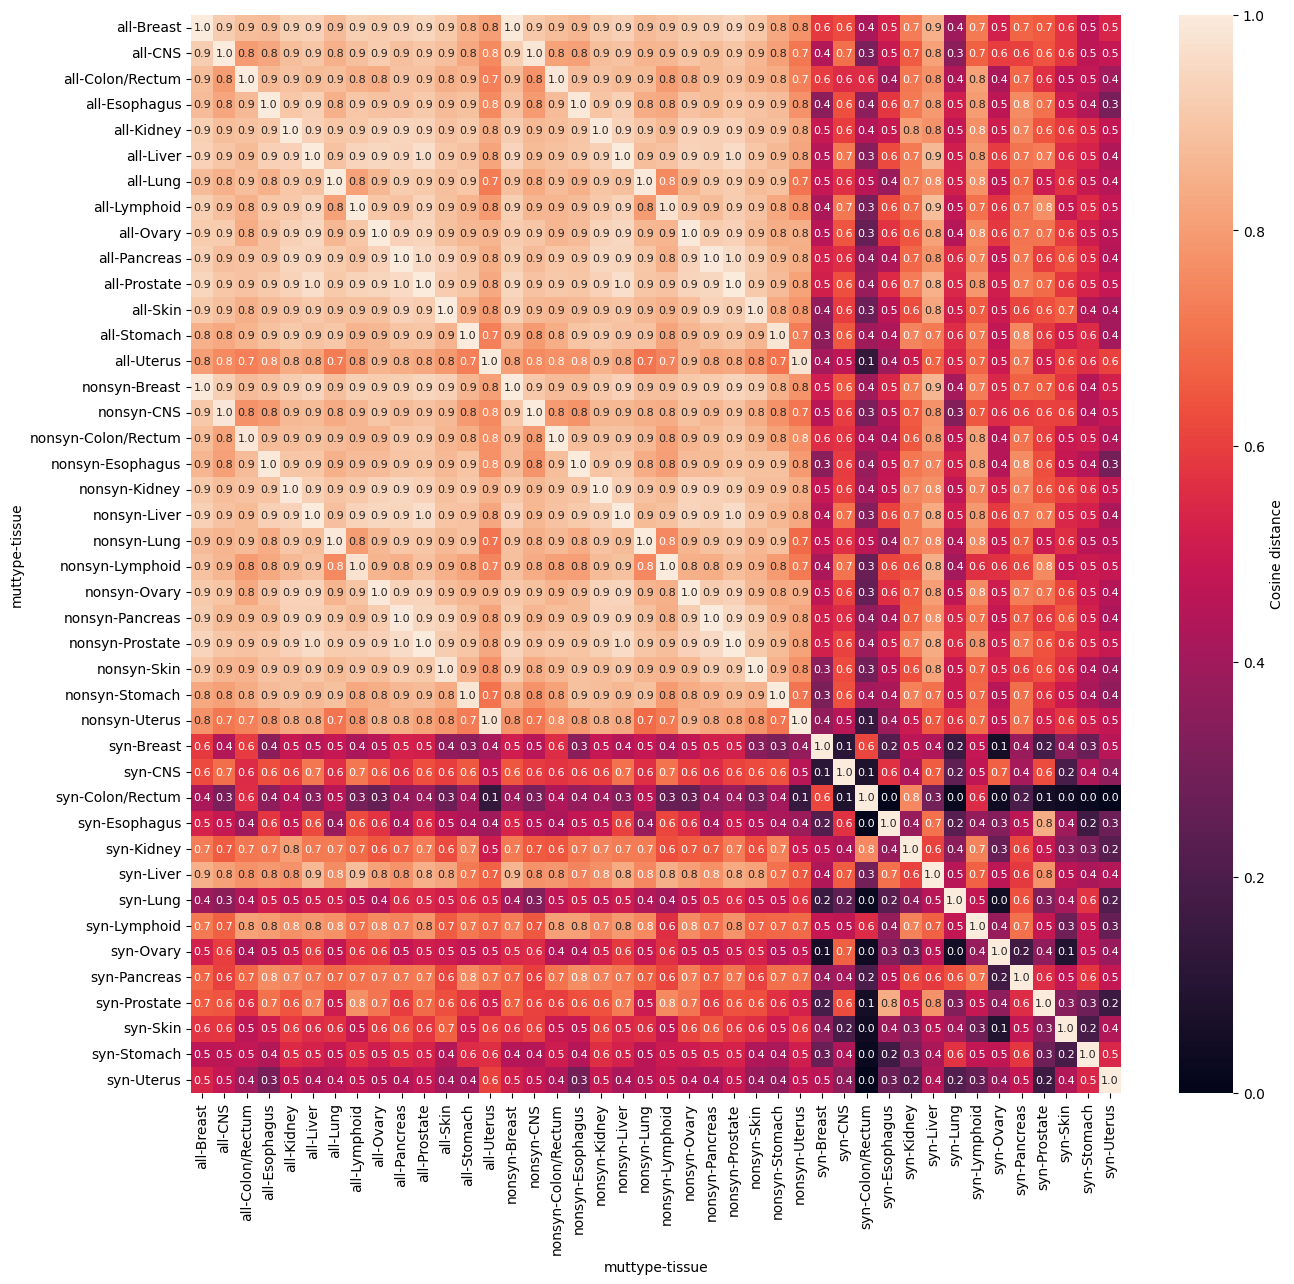

In [40]:
# visualyze this table in heatmap style
# we see that syn spectra of almost all tissues are dissimilar with non-syn spectra
_x = spectra_tissue_specific_wide.loc[df_compare_all_syn.tissue.values[1:]]
_x.index = _x.index.reorder_levels([1,0])
_x = _x.sort_index()

d = pd.DataFrame(1 - squareform(pdist(_x, 'cosine')), columns=_x.index, index=_x.index)

plt.figure(figsize=(15, 14))
ax = sns.heatmap(d, annot=True, fmt='.1f', annot_kws={'fontsize': 8}, vmin=0.,
            cbar_kws={'label': 'Cosine distance'})

In [43]:
# these dissimilarities reason is a big number of zeroes in the syn spectra:
# this table show number of non-zero values in tissue-specific diffrerent spectra 
(spectra_tissue_specific_wide > 0).sum(axis=1).unstack()

muttype,all,nonsyn,syn
tissue,,,
All tissues,160,155,93
Breast,88,77,42
CNS,64,53,25
Colon/Rectum,58,54,21
Esophagus,77,71,34
Kidney,97,93,50
Liver,95,88,58
Lung,53,51,19
Lymphoid,72,64,32


# Prepare SYN cancer sample spectra to compare with vertebrata classes spectra

### Generate patient-specific spectra samples

In [50]:
obs_syn = obs_all[obs_all.Label > 0]
patient_obs = obs_syn.groupby('sample').Mut.value_counts().unstack().fillna(0.)
patient_exp = pd.DataFrame([exp_syn_freqs])[patient_obs.columns]
patient_exp = pd.concat([patient_exp for _ in range(len(patient_obs))])
patient_exp.index = patient_obs.index

patient_spectra = patient_obs / patient_exp # mustn't scale due to single mutations in many spectra
patient_spectra['nobs'] = patient_obs.sum(axis=1)
patient_spectra.to_csv('./data/human_cancer_spectra_patient_specific_syn.csv')
patient_spectra

Mut,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,A[G>A]A,A[G>A]C,...,T[G>A]G,T[G>A]T,T[G>C]C,T[G>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]G,nobs
sample,,,,,,,,,,,,,,,,,,,,,
0007_CRUK_PC_0007,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
0064_CRUK_PC_0064,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.009524,0.0,0.0,0.0,0.0,1.0
0071_CRUK_PC_0071,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.0
0078b0c4-68a9-483b-9aab-61156d263213,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
0082_CRUK_PC_0082,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fafd4576-0709-49e1-926f-ad1ee09907ec,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.0
fba80122-d8b2-4d8d-a032-9767e8160f9f,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.009524,0.0,0.0,0.0,0.0,2.0
fd9ee494-65fe-4de4-adff-7952a059b17f,0.0,0.0,0.0,0.0,0.0,0.008772,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0


In [41]:
# patient_spectra  = pd.read_csv('../data/human_cancer_spectra_patient_specific_syn.csv', index_col=0)
# patient_spectra.columns.name = 'Mut'
# patient_spectra

In [51]:
# calculate non-scaled SYN spectra by averaging patiant specific spectra (just check) 
patient_spectra_mean = patient_spectra.mean().rename('MutSpec').reset_index()
print(patient_spectra_mean.MutSpec.sum())
patient_spectra_mean

1.2797539157607085


,Mut,MutSpec
0,A[A>G]A,0.000019
1,A[A>G]C,0.000093
2,A[A>G]G,0.000090
3,A[A>G]T,0.000168
4,A[C>T]A,0.000192
...,...,...
89,T[T>C]C,0.000430
90,T[T>C]G,0.000554
91,T[T>C]T,0.000343
92,T[T>G]G,0.000400


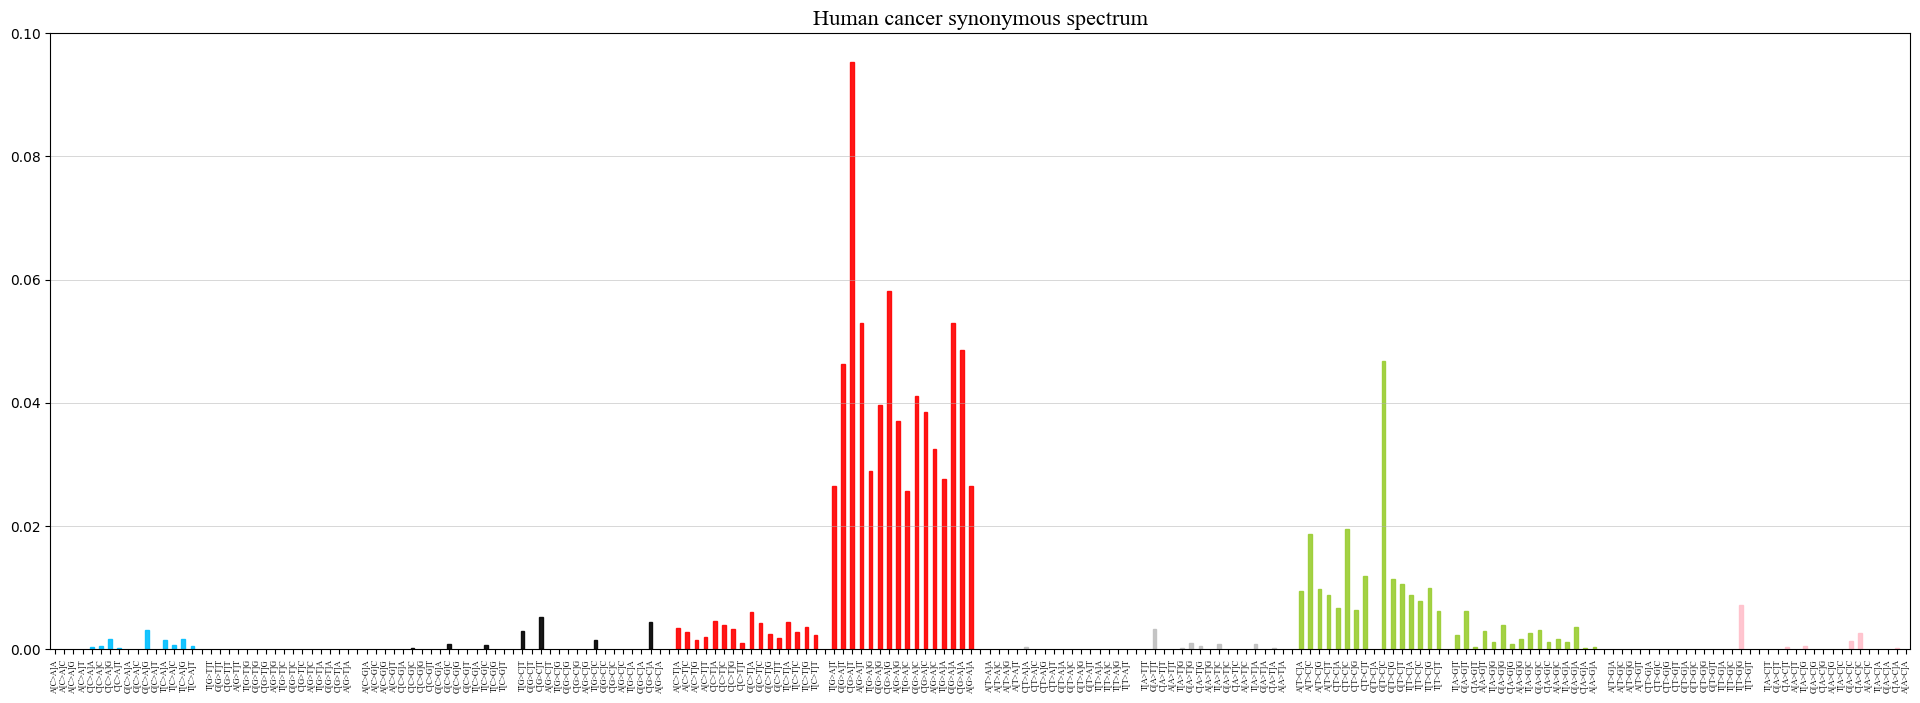

In [52]:
# show average syn spectra (L-strtand)
patient_spectra_mean = patient_spectra_mean[patient_spectra_mean.Mut != 'nobs']
patient_spectra_mean['MutSpec'] /= patient_spectra_mean['MutSpec'].sum()
plot_mutspec192(patient_spectra_mean, title='Human cancer synonymous spectrum');

In [53]:
# get transitins list in the 192-comp spectra
# ts = [x for x in possible_sbs192 if x[2:5] in ['C>T', 'T>C', 'G>A', 'A>G',]]

In [54]:
cancer_syn_spectrum = spectra_tissue_specific_wide.loc[[('All tissues', 'syn')]][possible_sbs192]
cancer_syn_spectrum

,Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
tissue,muttype,,,,,,,,,,,,,,,,,,,,,
All tissues,syn,0.0,0.0,0.0,0.0,0.000262,0.002646,0.0,0.000335,0.0,0.001323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007217,0.0


In [55]:
# number of patient syn spectra
patient_spectra.shape

(682, 94)

### Estimate best number of patients in one sample

In [56]:
nsamples = 1000

for npatients in range(50, 501, 50):
    d = []
    for i in range(nsamples):
        patient_spectra_mean = patient_spectra.sample(npatients, replace=False)\
            .sum().rename('MutSpec').reset_index().assign(sample=i)
        d.append(patient_spectra_mean)

    spectra_syn_samples = pd.concat(d, ignore_index=True)
    spectra_syn_samples_wide = spectra_syn_samples.pivot('sample', 'Mut', 'MutSpec')
    spectra_syn_samples_wide.index = ['sample' for _ in range(nsamples)]
    spectra_syn_samples_wide = complete_sbs192_columns(spectra_syn_samples_wide)
    
    # stats:
    nobs_mean = spectra_syn_samples[spectra_syn_samples.Mut == 'nobs'].MutSpec.mean()
    cossim_samp_vs_samp = 1-pdist(spectra_syn_samples_wide, 'cosine')
    cossim_tis_vs_samples = 1-cdist(cancer_syn_spectrum, spectra_syn_samples_wide[possible_sbs192], 
                                    'cosine').flatten()
    print('npatients =', npatients)
    print('nobs mean =', nobs_mean)
    print('cossim_samp_vs_samp', np.quantile(cossim_samp_vs_samp,   [0., .25, .5, .75, 1.]).round(2))
    print('cossim_tis_vs_samples',np.quantile(cossim_tis_vs_samples, [0., .25, .5, .75, 1.]).round(2))
    print()

npatients = 50
nobs mean = 61.372
cossim_samp_vs_samp [0.02 0.4  0.52 0.63 0.96]
cossim_tis_vs_samples [0.43 0.66 0.73 0.78 0.92]

npatients = 100
nobs mean = 122.465
cossim_samp_vs_samp [0.19 0.63 0.7  0.77 0.97]
cossim_tis_vs_samples [0.64 0.8  0.84 0.87 0.95]

npatients = 150
nobs mean = 183.835
cossim_samp_vs_samp [0.3  0.74 0.8  0.84 0.98]
cossim_tis_vs_samples [0.68 0.87 0.89 0.92 0.97]

npatients = 200
nobs mean = 244.961
cossim_samp_vs_samp [0.44 0.81 0.85 0.89 0.98]
cossim_tis_vs_samples [0.78 0.9  0.92 0.94 0.98]

npatients = 250
nobs mean = 306.089
cossim_samp_vs_samp [0.61 0.86 0.89 0.92 0.99]
cossim_tis_vs_samples [0.86 0.93 0.95 0.96 0.98]

npatients = 300
nobs mean = 366.854
cossim_samp_vs_samp [0.63 0.89 0.92 0.94 0.99]
cossim_tis_vs_samples [0.86 0.95 0.96 0.97 0.99]

npatients = 350
nobs mean = 428.687
cossim_samp_vs_samp [0.71 0.92 0.94 0.95 0.99]
cossim_tis_vs_samples [0.89 0.96 0.97 0.98 0.99]

npatients = 400
nobs mean = 489.241
cossim_samp_vs_samp [0.78 0.94 0.95

300-350 patients is the satisfactory number, i.e. we can sample just 50% of patients

### Generate spectra samples: Sample 50% of patients 1000 times and calculate average spectra

In [57]:
nsamples = 1000
# npatients = 300 # avaraged to get aggregative spectrum
d = []
for i in range(nsamples):
    patient_spectra_mean = patient_spectra.sample(frac=0.5, replace=False)\
        .sum().rename('MutSpec').reset_index().assign(sample=i)
    d.append(patient_spectra_mean)

spectra_syn_samples = pd.concat(d, ignore_index=True)
spectra_syn_samples_wide = spectra_syn_samples.pivot('sample', 'Mut', 'MutSpec')
spectra_syn_samples_wide.index = ['sample' for _ in range(nsamples)]
spectra_syn_samples_wide = complete_sbs192_columns(spectra_syn_samples_wide)
spectra_syn_samples_wide.head(2)

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
sample,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.012658,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0
sample,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0


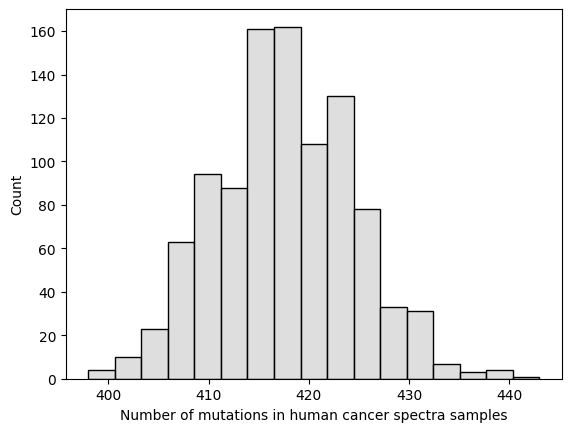

In [58]:
# distribution of number of mutations used in sample spectra generation 
sns.histplot(spectra_syn_samples[spectra_syn_samples.Mut == 'nobs'].MutSpec, bins=17, color='lightgray')\
    .set_xlabel('Number of mutations in human cancer spectra samples')
plt.savefig('./figures/cancer_samples_nmut.png');

In [59]:
# compare samples spectra pairwisely
cossim_samp_vs_samp = 1-pdist(spectra_syn_samples_wide, 'cosine')
# compare samples spectra with total spectra based on all SYN mutations (tis label)
cossim_tis_vs_samples = 1-cdist(cancer_syn_spectrum, spectra_syn_samples_wide[possible_sbs192], 
                                'cosine').flatten()

print('cossim_samp_vs_samp', np.quantile(cossim_samp_vs_samp,   [0., .25, .5, .75, 1.]).round(2))
print('cossim_tis_vs_samples',np.quantile(cossim_tis_vs_samples, [0., .25, .5, .75, 1.]).round(2))

cossim_samp_vs_samp [0.7  0.91 0.93 0.95 0.99]
cossim_tis_vs_samples [0.89 0.96 0.97 0.97 0.99]


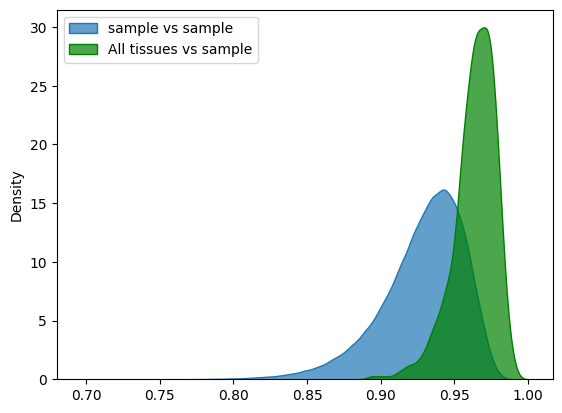

In [60]:
# plot distributions of these compares
sns.kdeplot(cossim_samp_vs_samp, label='sample vs sample', fill=True, alpha=0.7)
sns.kdeplot(cossim_tis_vs_samples, color='green', label='All tissues vs sample', fill=True, alpha=0.7)
plt.legend(loc='upper left')
plt.show()

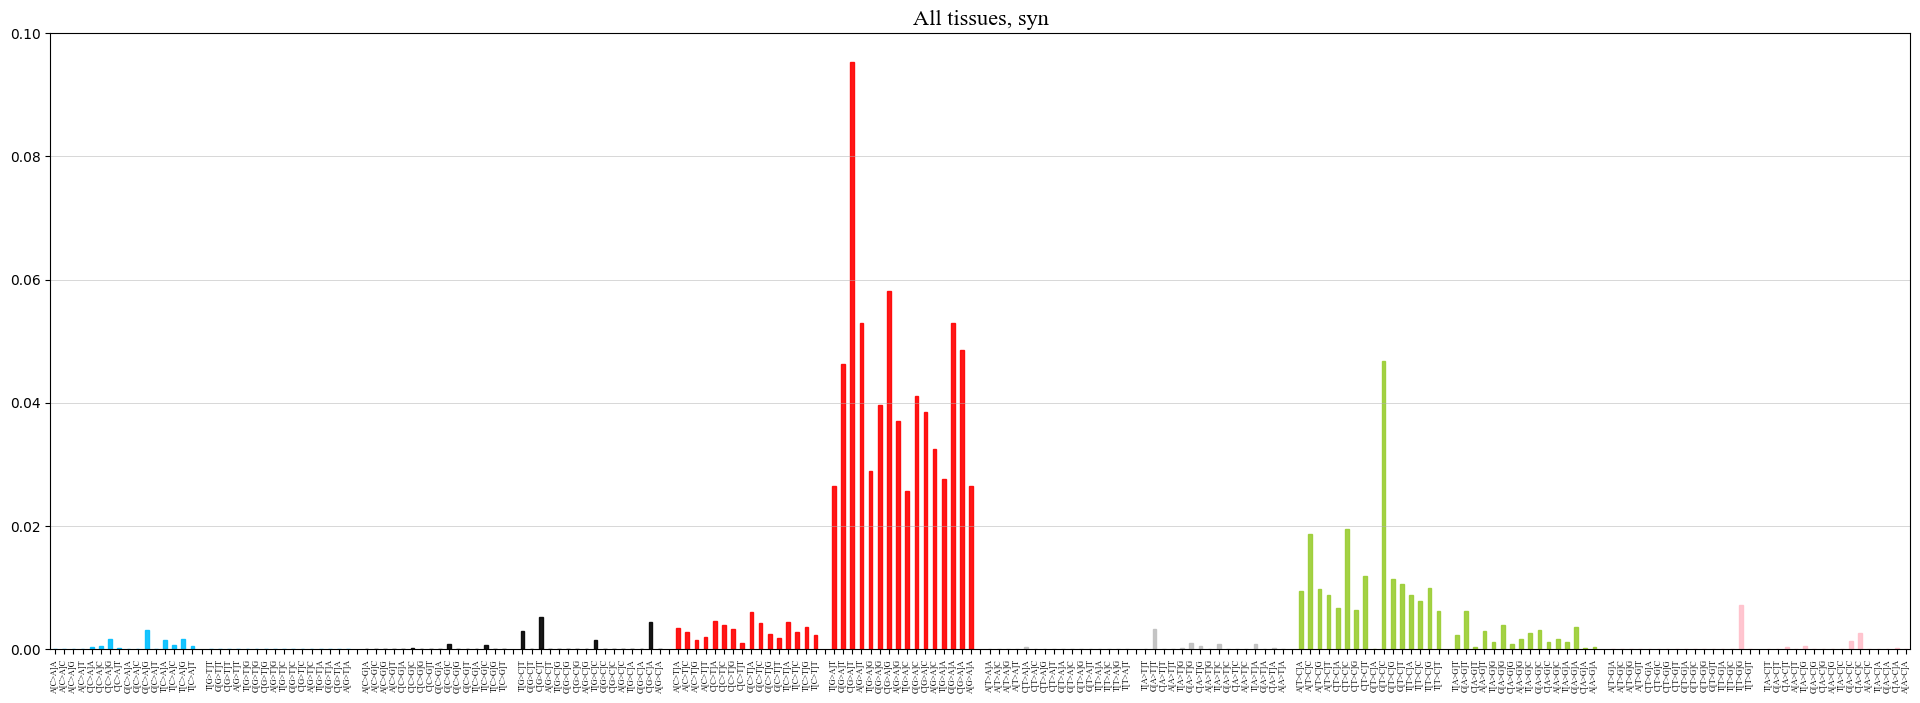

In [61]:
# plot again total syn spectrum (L-strand)
plot_mutspec192(cancer_syn_spectrum.iloc[0].rename('MutSpec').reset_index(), title='All tissues, syn');

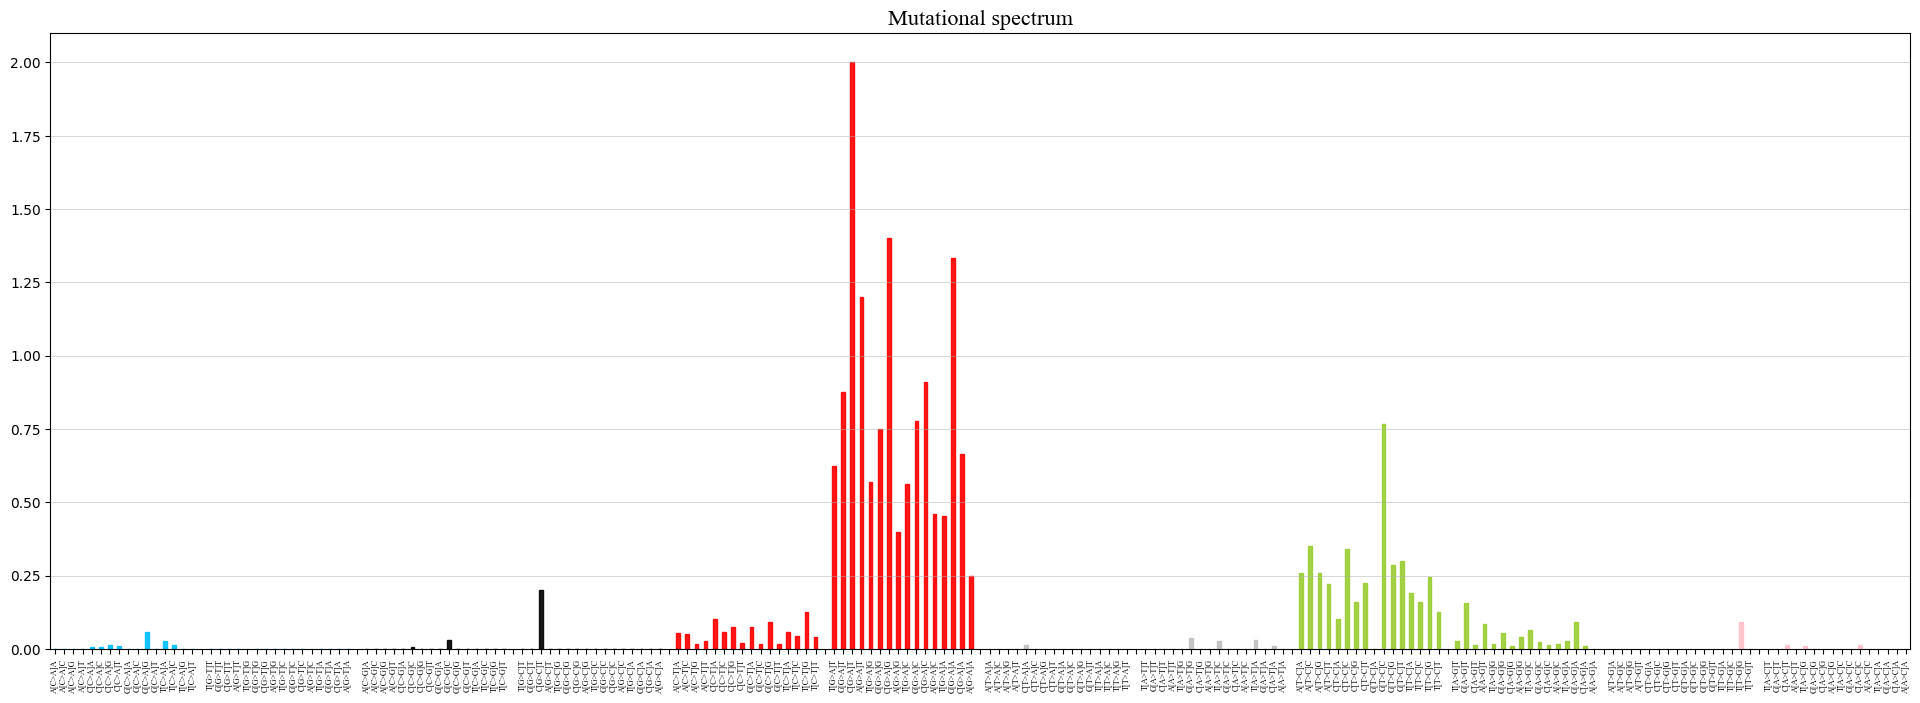

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [62]:
# and plotsample syn spectrum (L-strand)
# we see that they are similar but different
plot_mutspec192(spectra_syn_samples_wide.iloc[0].rename('MutSpec').reset_index())

### Compare samples spectra on 2d-space using UMAP

In [63]:
umap.__version__

'0.5.6'

In [64]:
# only syn tissues
spectra_tissue_specific_wide_syn = spectra_tissue_specific_wide.reset_index(level=1)
spectra_tissue_specific_wide_syn = spectra_tissue_specific_wide_syn[
    spectra_tissue_specific_wide_syn.muttype == 'syn'].drop('muttype', axis=1)

# assert (spectra_tissue_specific_wide_syn.columns == spectra_syn_samples_wide.columns).all()

# concatenate only transitions
full_data = pd.concat([spectra_tissue_specific_wide_syn, 
                       spectra_syn_samples_wide])
print('input data shape:', full_data.shape)
# Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(full_data)
scaled_data = (full_data.T / full_data.sum(axis=1)).T

# Create UMAP instance and fit the data
umap_instance = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine',  random_state=777)#, learning_rate=2., n_epochs=100000)
umap_result = umap_instance.fit_transform(scaled_data)

# Create a new dataframe with the UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['tissue'] = full_data.index.values
umap_df['type'] = umap_df['tissue'].apply(lambda x: x if x == 'sample' else 'tissue')
print(umap_df.shape)
umap_df.head()

input data shape: (1015, 192)
(1015, 4)


,UMAP1,UMAP2,tissue,type
0,6.571702,4.865252,All tissues,tissue
1,2.850173,4.371055,Breast,tissue
2,7.920278,5.516703,CNS,tissue
3,4.660600,5.049137,Colon/Rectum,tissue
4,10.423310,4.285258,Esophagus,tissue


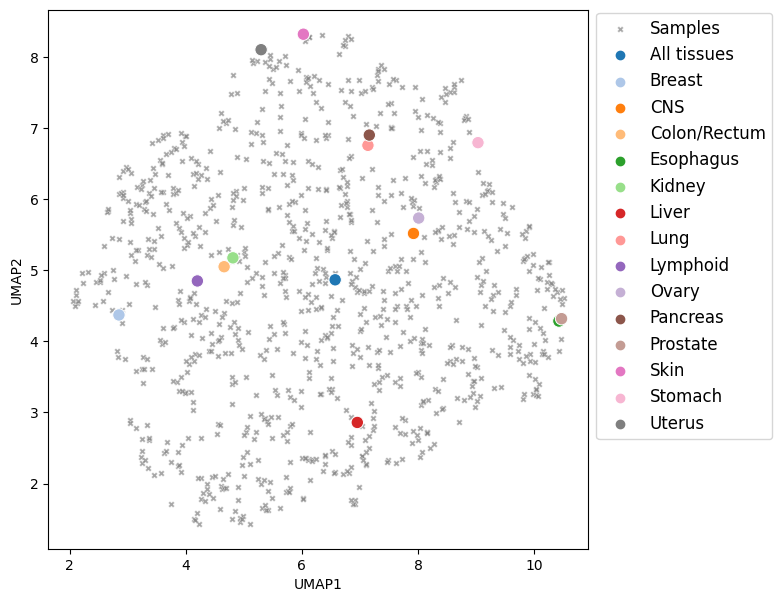

In [65]:
plt.figure(figsize=(8,7))
ax = sns.scatterplot(data=umap_df.iloc[15:], x='UMAP1', y='UMAP2', 
                     marker='X', s=20, alpha=0.7, color='gray', label='Samples', legend=True)
ax = sns.scatterplot(data=umap_df.head(15),  x='UMAP1', y='UMAP2', 
                     hue='tissue', palette='tab20', marker='o', s=80, ax=ax)

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
plt.savefig('./figures/human_cancer_spectra_syn_samples_umap.png', bbox_inches='tight')
plt.show()

We see that samples cover all space around total SYN spectrum and include all tissues, that means that we use satisfactory sample spectra

Such sampling (jacknife-50%) used in the `3compare_classes/similarity_jack.ipynb` notebook during vertebrates classes spectra compares

### Compare number of mutations in classes spectra and cancer spectra

In [66]:
sp192vert = pd.read_csv('../1data_derivation/dataset/MutSpecVertebrates192.csv.gz')
sp192vert = sp192vert[sp192vert.Gene == 'Cytb']

In [67]:
sp192vert.groupby(['Gene', 'Class']).Species.nunique().unstack()

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
Gene,,,,,
Cytb,523,76,130,177,791


In [68]:
species_nobs = sp192vert.groupby(['Class', 'Species']).Observed.sum()
species_nobs = species_nobs[species_nobs>0]
species_nobs.describe() #.hist(bins=100)

count    1697.000000
mean       69.768354
std        70.279360
min        20.005172
25%        30.533166
50%        44.669452
75%        78.712927
max       661.120470
Name: Observed, dtype: float64

In [69]:
data = []
for _ in range(1000):
    d = species_nobs.reset_index().groupby('Class').sample(50, replace=False)\
        .set_index(['Class', 'Species']).sum(level=0).Observed.to_dict()
    data.append(d)

df = pd.DataFrame(data)

In [70]:
df['Cancer'] = spectra_syn_samples[spectra_syn_samples.Mut == 'nobs'].MutSpec

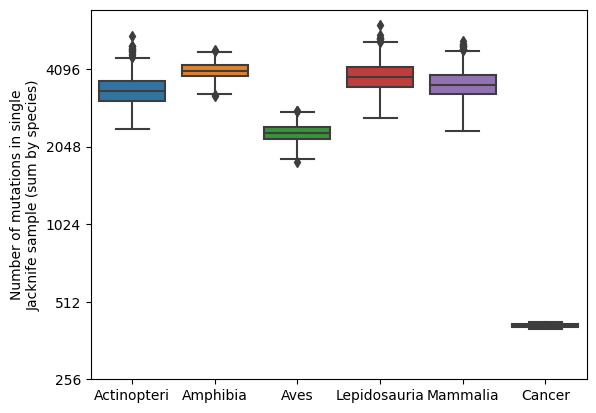

In [71]:
ax = sns.boxplot(df)
ax.set_ylabel('Number of mutations in single\nJacknife sample (sum by species)')
# plt.xticks(rotation=45)
plt.yscale('log', base=2)
plt.yticks(np.logspace(8, 12, 5, base=2), np.logspace(8, 12, 5, base=2, dtype='int'))
plt.savefig('./figures/nmuts_classes_cancer.png')
plt.show()